In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.linear_model import Ridge, RidgeCV

# PCR 和 PLS 回归

本实验是对《Introduction to Statistical Learning with Applications in R》一书第256-259页内容的 Python 版本改编。该书由 Gareth James、Daniela Witten、Trevor Hastie 和 Robert Tibshirani 编写。

在本实验中，我们实现了本章讨论的许多技术。

## 手动实现主成分回归（Principal Components Regression）

主成分回归（PCR）可以使用 `sklearn.decomposition` 模块中的 `PCA()` 方法实现。现在，我们将对 `Hitters` 数据集应用 PCR，以预测 `Salary`。

In [2]:
Hitters = pd.read_csv("../Data/Hitters.csv")
Hitters

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [3]:
np.isnan(
    Hitters["Salary"]
).sum()  # Np.isnan Test element-wise for NaN and return result as a boolean array.

59

我们发现有 59 名球员的 **Salary** 数据缺失。数据框中的 `dropna()` 方法会移除所有包含缺失值的行（默认行为——详情见 `Hitters.dropna?`）。

In [4]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [5]:
# create Dummies Variables to transform Qualitative variables in 0-1 variables
dummies = pd.get_dummies(Hitters[["League", "Division", "NewLeague"]]).astype("float64")

Y = np.array(Hitters["Salary"])

# Drop the column with the independent variable (Salary), and columns for which we created dummy variables
X_ = Hitters.drop(["Salary", "League", "Division", "NewLeague"], axis=1).astype(
    "float64"
)

# Define the feature set X.
X = pd.concat([X_, dummies[["League_N", "Division_W", "NewLeague_N"]]], axis=1)

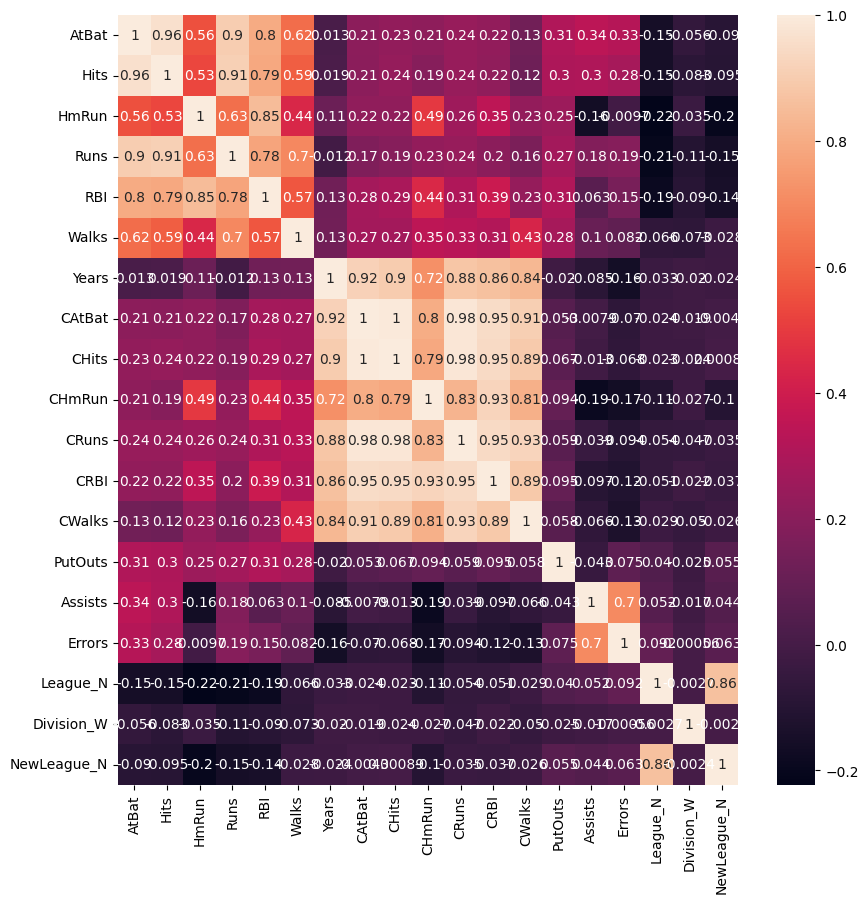

In [6]:
# Exploration
plt.figure(figsize=(10, 10))
sns.heatmap(X.corr(), annot=True)
plt.show()

在数据中存在多重共线性（multicollinearity）的情况。因此，我们在对标准化后的特征进行主成分分析（PCA）后，使用 `LinearRegression()` 来拟合回归模型。需要注意的是，`LinearRegression()` 默认会拟合截距（intercept），这与 `OLS()` 函数的行为有所不同。

In [7]:
pca = PCA()
X_reduced = pca.fit_transform(scale(X))
regr = LinearRegression()
regr.fit(X_reduced, Y)
regr.coef_

array([ 106.36859204,   21.60350456,   24.2942534 ,  -36.9858579 ,
        -58.41402748,   62.20632652,   24.63862038,  -15.82817701,
         29.57680773,   99.64801199,   30.11209105,  -20.99269291,
        -72.40210574, -276.68551696,  -74.17098665,  422.72580227,
        347.05662353, -561.59691587,  -83.25441536])

我们使用交叉验证（CV，Cross-Validation）来选择主成分的数量，以确保模型的性能最佳。

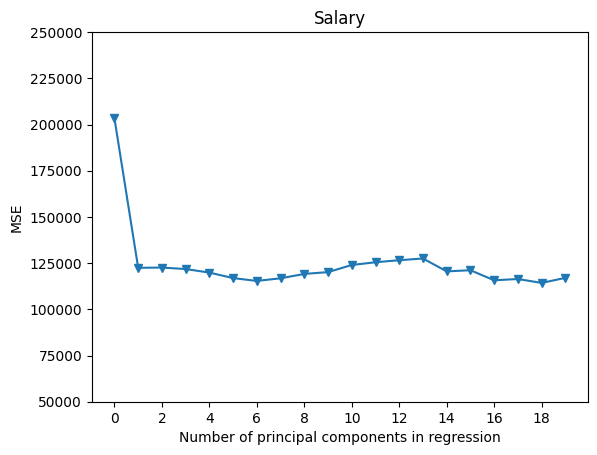

In [8]:
# 10-fold CV, with shuffle
n = len(X_reduced)
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

regr = LinearRegression()
mse = []
std = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -model_selection.cross_val_score(
    regr, np.ones((n, 1)), Y.ravel(), cv=kf_10, scoring="neg_mean_squared_error"
).mean()
mse.append(score)
score = -model_selection.cross_val_score(
    regr, np.ones((n, 1)), Y.ravel(), cv=kf_10, scoring="neg_root_mean_squared_error"
).mean()
std.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at the time
for i in np.arange(1, 20):
    score = -model_selection.cross_val_score(
        regr, X_reduced[:, :i], Y.ravel(), cv=kf_10, scoring="neg_mean_squared_error"
    ).mean()
    mse.append(score)
    score = -model_selection.cross_val_score(
        regr,
        X_reduced[:, :i],
        Y.ravel(),
        cv=kf_10,
        scoring="neg_root_mean_squared_error",
    ).mean()
    std.append(score)

n_comp = range(0, 20)
# Plot results
plt.plot(n_comp, mse, "v-")
plt.xlabel("Number of principal components in regression")
plt.ylabel("MSE")
plt.title("Salary")
plt.xticks(n_comp[::2])
plt.ylim([50000, 250000])
plt.show()

In [9]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4) * 100)

array([38.31, 60.15, 70.84, 79.03, 84.29, 88.63, 92.26, 94.96, 96.28,
       97.25, 97.97, 98.64, 99.14, 99.46, 99.73, 99.88, 99.95, 99.98,
       99.99])

我们将数据分为训练集和测试集，并拟合一个“经典回归模型”（classical regression）作为基准模型（benchmark）。

In [10]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(
    X, Y, test_size=0.3, random_state=42, shuffle=False
)

regr_cla = LinearRegression()
regr_cla.fit(X_train, Y_train)

pred_cla = regr_cla.predict(X_test)
mse_cla = mean_squared_error(Y_test, pred_cla)

在将数据分为训练集和测试集之后，我们进行交叉验证（CV），以选择主成分的数量。这一步确保模型在训练集上表现最佳，并避免过拟合测试集。

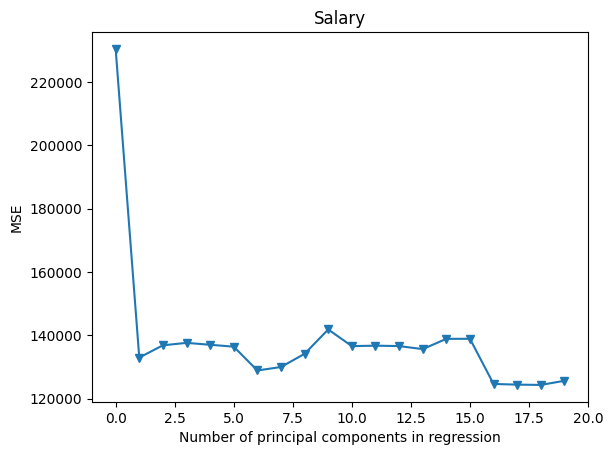

In [11]:
# Scale the data
X_reduced_train = pca.fit_transform(scale(X_train))
n = len(X_reduced_train)

# 10-fold CV, with shuffle
kf_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)
mse = []

# Calculate MSE with only the intercept (no principal components in regression)
score = -model_selection.cross_val_score(
    regr, np.ones((n, 1)), Y_train.ravel(), cv=kf_10, scoring="neg_mean_squared_error"
).mean()
mse.append(score)

# Calculate MSE using CV for the 19 principal components, adding one component at a time
for i in np.arange(1, 20):
    score = -model_selection.cross_val_score(
        regr,
        X_reduced_train[:, :i],
        Y_train.ravel(),
        cv=kf_10,
        scoring="neg_mean_squared_error",
    ).mean()
    mse.append(score)

# Plot the results
plt.plot(np.array(mse), "v-")
plt.xlabel("Number of principal components in regression")
plt.ylabel("MSE")
plt.title("Salary")
plt.xlim((-1, 20))
plt.show()

最佳模型似乎是选择了 $M=6$ 个主成分的模型。我们可以看到，$M=6$ 个主成分解释了超过 88% 的方差，这表明该模型在降低维度的同时仍然保留了大部分信息。

In [12]:
X_reduced_test = pca.transform(scale(X_test))[:, :7]

regr = LinearRegression()
regr.fit(X_reduced_train[:, :7], Y_train)

pred = regr.predict(X_reduced_test)
mse_PCR = mean_squared_error(Y_test, pred)

## 使用 _Pipeline_ 指令进行 PCR 回归

在对特征进行“标准化”处理之后，我们进行 PCR 回归。`Pipeline` 指令允许构建一个组合估计器（composite estimator），其中转换器（transformers）通常与其他转换器或预测器（例如分类器或回归器）结合使用。

In [13]:
scaler = StandardScaler(with_mean=True, with_std=True)
pca = PCA()
linreg = skl.LinearRegression()
pipe = Pipeline([("scaler", scaler), ("pca", pca), ("linreg", linreg)])

pipe.fit(X_train, Y_train)
pipe.named_steps["linreg"].coef_

array([ 111.19282939,   13.08948379,   27.08722312,  -36.99020216,
        -54.21824895,  101.24248755,   -3.13137637,  -19.76964084,
         41.23998637, -180.10024372,   40.77509567,  -81.85930853,
       -231.25846024,   15.80787036, -193.45982805,  620.94321009,
        305.37515602, -529.4531879 , -303.31830547])

我们观察到，回归系数与之前的方法一致。

当然，我们可以使用交叉验证（CV）来选择主成分的数量。通过使用 `skm.GridSearchCV`，我们可以在固定其他参数的情况下，调整 `n_components` 参数，以确定最佳的主成分数量。

In [14]:
K = 5
kfold = skm.KFold(K, random_state=42, shuffle=True)
param_grid = {"pca__n_components": range(1, 20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring="neg_mean_squared_error")
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

让我们像对其他方法一样绘制结果图。

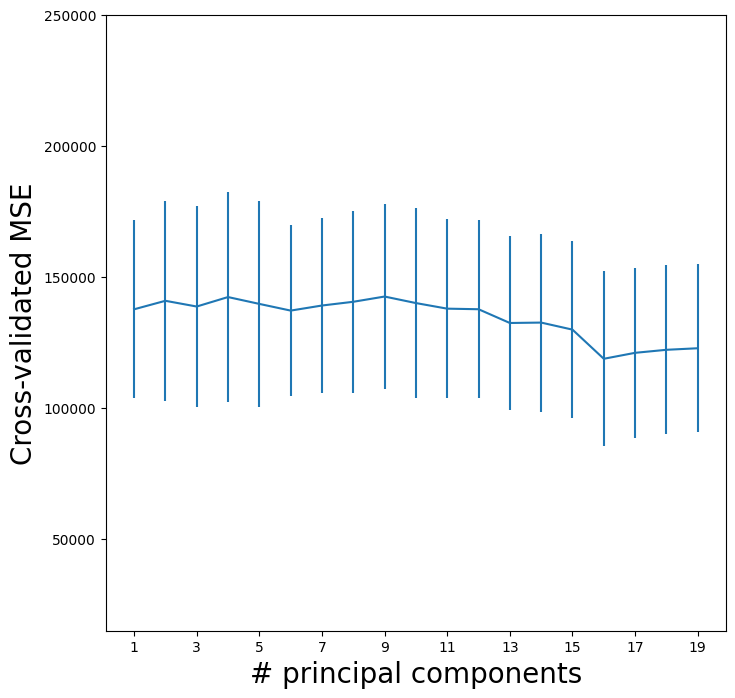

In [15]:
pcr_fig, ax = subplots(figsize=(8, 8))
n_comp = param_grid["pca__n_components"]
ax.errorbar(
    n_comp,
    -grid.cv_results_["mean_test_score"],
    grid.cv_results_["std_test_score"] / np.sqrt(K),
)
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([15000, 250000])
plt.show()

z = grid.cv_results_["std_test_score"] / np.sqrt(K)

我们发现，当使用 6 个主成分时，交叉验证误差达到最小。然而，从图中也可以看出，当模型仅包含 1 个主成分时，交叉验证误差几乎相同。这表明，使用少量主成分的模型可能已经足够。

交叉验证分数（CV score）会针对从 1 到 19（含）的每个可能的主成分数量提供结果。值得注意的是，如果尝试仅使用 `n_components=0` 来拟合截距，`PCA()` 方法会报错。因此，我们还针对这些数据分割计算了仅使用空模型（null model）的均方误差（MSE）。

In [16]:
Xn = np.zeros((X_train.shape[0], 1))
cv_null = skm.cross_validate(
    linreg, Xn, Y_train, cv=kfold, scoring="neg_mean_squared_error"
)
-cv_null["test_score"].mean()

230687.0498730326

`PCA` 对象的 `explained_variance_ratio_` 属性提供了不同数量主成分所解释的**预测变量和响应变量的方差百分比**。通过该属性，我们可以了解每个主成分在数据中的贡献。

In [17]:
pipe.named_steps["pca"].explained_variance_ratio_

array([4.17560405e-01, 1.93845849e-01, 9.81112735e-02, 9.16961452e-02,
       5.11588406e-02, 4.44580011e-02, 3.06626634e-02, 2.59523093e-02,
       1.24572994e-02, 8.80163724e-03, 7.83621469e-03, 5.89332770e-03,
       3.63004129e-03, 3.52351616e-03, 2.27754319e-03, 1.21318336e-03,
       5.77587091e-04, 2.86564312e-04, 5.75984462e-05])

简而言之，我们可以将这理解为使用 $M$ 个主成分捕获的预测变量信息量。例如：

- 设置 $M=1$ 时，仅捕获 38.31% 的方差；
- 增加到 $M=2$ 时，额外捕获 21.84%，总计捕获 60.15% 的方差；
- 增加到 $M=6$ 时，捕获比例进一步增加到 88.63%。

在此之后，增量逐渐减少，直到使用所有 $M=p=19$ 个主成分时，捕获了 100% 的方差。

## 偏最小二乘回归（Partial Least Squares Regression）

偏最小二乘回归（PLS）可以通过 `PLSRegression()` 函数实现。

In [18]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X_train, Y_train)

PLSRegression()

与 PCR 情况类似，我们需要使用交叉验证（CV）来选择主成分的数量，以确保模型的性能最佳。

In [19]:
param_grid = {"n_components": range(1, 20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, scoring="neg_mean_squared_error")
grid.fit(X_train, Y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

和其他方法一样，我们绘制均方误差（MSE）的图表，以直观展示模型性能随主成分数量变化的趋势。

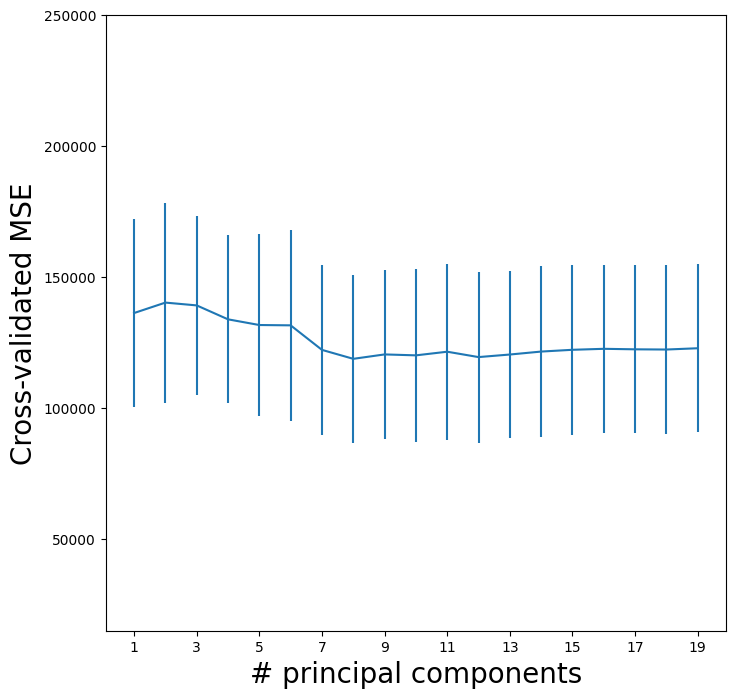

In [20]:
pls_fig, ax = subplots(figsize=(8, 8))
n_comp = param_grid["n_components"]
ax.errorbar(
    n_comp,
    -grid.cv_results_["mean_test_score"],
    grid.cv_results_["std_test_score"] / np.sqrt(K),
)
ax.set_ylabel("Cross-validated MSE", fontsize=20)
ax.set_xlabel("# principal components", fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([15000, 250000])
plt.show()

z = grid.cv_results_["std_test_score"] / np.sqrt(K)

交叉验证误差在使用 12 个主成分时达到最小，但在较低的主成分数量（例如 2 或 3 个）时，误差差异并不明显。接下来，我们在测试集上计算均方误差（MSE）以评估模型性能。

In [21]:
pls = PLSRegression(n_components=8, scale=True)
pls.fit(X_train, Y_train)
pred = pls.predict(X_test)
mse_PLS = mean_squared_error(Y_test, pred)

测试数据上不同模型的 MSE 比较。

In [22]:
mse_tuples = [("Classical", mse_cla), ("PCR", mse_PCR), ("PLS", mse_PLS)]

sorted(mse_tuples, key=lambda mse: mse[1])

[('PCR', 96043.58804121573),
 ('Classical', 116358.21243346678),
 ('PLS', 116596.87394248796)]

## 岭回归（Ridge Regression）

In [23]:
lambdas = 10 ** np.linspace(8, -2, 100) / Y.std()
ridgeReg = Ridge(alpha=lambdas[59])

ridgeReg.fit(X_train, Y_train)

Ridge(alpha=0.24374766133488554)

我们还可以绘制线性模型和岭回归模型的系数图。

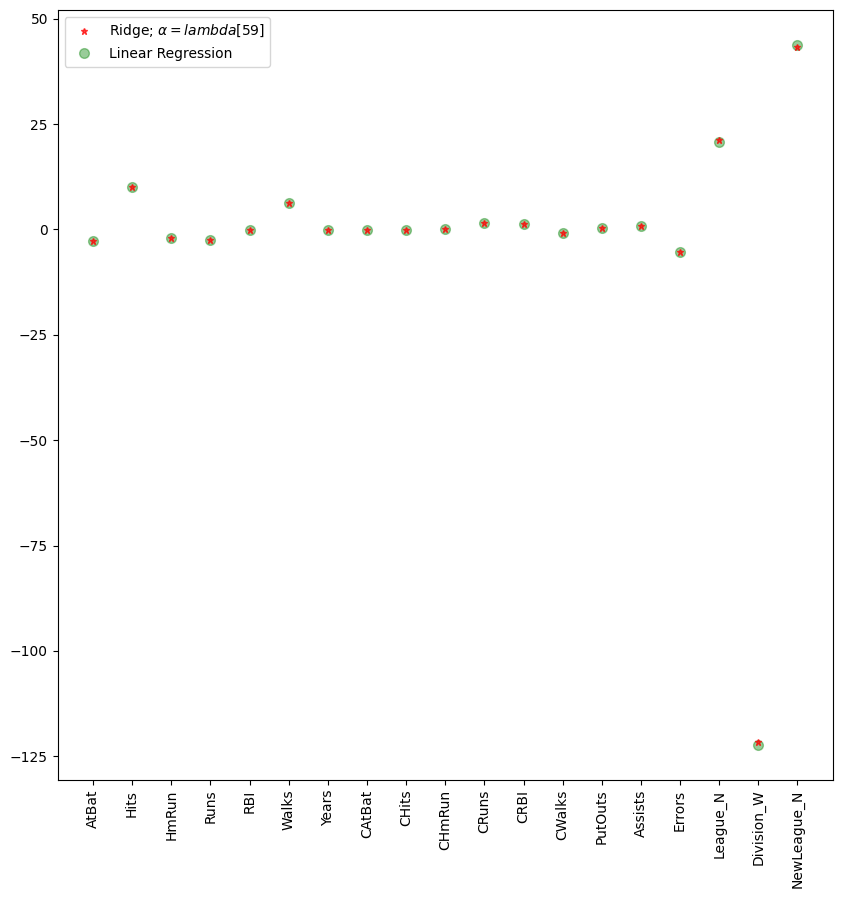

In [24]:
features = X.columns[0:19]

plt.figure(figsize=(10, 10))
plt.plot(
    features,
    ridgeReg.coef_,
    alpha=0.7,
    linestyle="none",
    marker="*",
    markersize=5,
    c="red",
    label=r"Ridge; $\alpha = lambda[59]$",
    zorder=7,
)
plt.plot(
    features,
    regr_cla.coef_,
    alpha=0.4,
    linestyle="none",
    marker="o",
    markersize=7,
    c="green",
    label="Linear Regression",
)
plt.xticks(rotation=90)
plt.legend()
plt.show()

对数据进行标准化后，通过交叉验证选择正则化参数 $\lambda$。

In [25]:
ridgeReg = Ridge(alpha=lambdas[59])
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[("scaler", scaler), ("ridge", ridgeReg)])
pipe.fit(X_train, Y_train)

param_grid = {"ridge__alpha": lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring="neg_mean_squared_error")

grid.fit(scale(X_train), Y_train)
grid.best_params_["ridge__alpha"]
grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', Ridge(alpha=0.9840135155514798))])

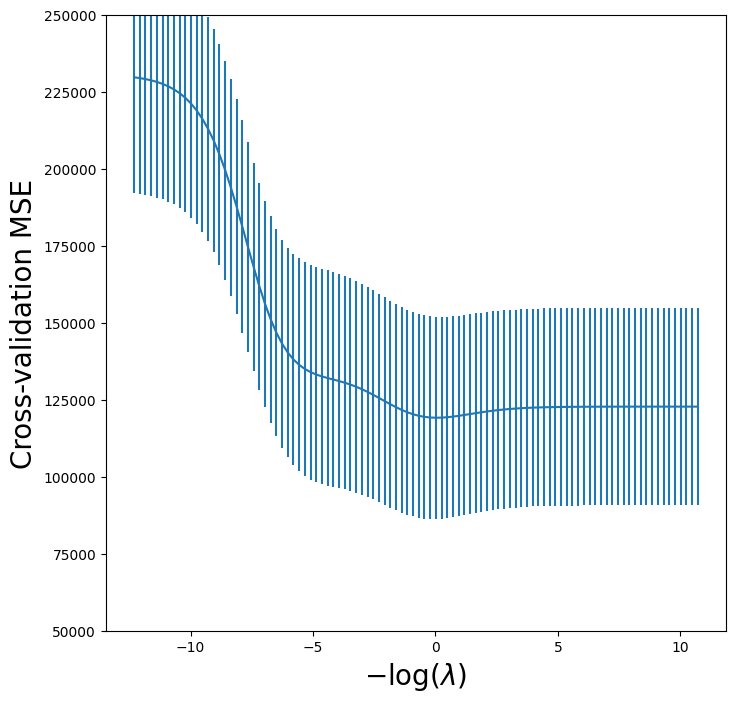

In [26]:
ridge_fig, ax = plt.subplots(figsize=(8, 8))
ax.errorbar(
    -np.log(lambdas),
    -grid.cv_results_["mean_test_score"],
    yerr=grid.cv_results_["std_test_score"] / np.sqrt(K),
)
ax.set_ylim([50000, 250000])
ax.set_xlabel("$-\log(\lambda)$", fontsize=20)
ax.set_ylabel("Cross-validation MSE", fontsize=20)
plt.show()

在测试数据上进行预测，并比较不同模型的均方误差（MSE）以评估其性能。

In [27]:
ridgeRegbest = Ridge(alpha=1.5668277892277)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[("scaler", scaler), ("ridge", ridgeRegbest)])
pipe.fit(X_train, Y_train)
pred_ridge = pipe.predict(X_test)
mse_ridge = mean_squared_error(Y_test, pred_ridge)

In [28]:
mse_tuples = [
    ("Classical", mse_cla),
    ("PCR", mse_PCR),
    ("PLS", mse_PLS),
    ("Ridge", mse_ridge),
]

sorted(mse_tuples, key=lambda mse: mse[1])

[('PCR', 96043.58804121573),
 ('Ridge', 110817.38797057682),
 ('Classical', 116358.21243346678),
 ('PLS', 116596.87394248796)]

比较最佳 Ridge 回归模型与未标准化数据的经典回归模型的回归系数。这将帮助我们了解 Ridge 正则化对模型系数的影响，以及在处理多重共线性时 Ridge 的作用。